## Demo Usage for the Language Collapse Methodology

### Part 1: Creating the Collapsed Dataset

Import all necessary libraries/scripts

In [12]:
from transformers import BertConfig
from utils import get_vocab_size, create_base_tokenizer
from matplotlib import pyplot as plt
from transformers import BertForMaskedLM
from bert import MAX_LEN, pad_and_mask, add_mlm_masking, train
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import pickle
from generator import create_dataset, get_collapsed_words

Specify collapse factor. Here we collapse the langauge 50%.

In [13]:
COLLAPSE_FACTOR = 1/0.5 # code uses inverse of the more readible factor, 0.5

Load the dataset and original model. Our work is done with the TinyStories dataset and model. Then, extract the embeddings from the model.

In [14]:
dataset = load_dataset('roneneldan/TinyStories')
dataset_train = dataset['train']
dataset_val = dataset['validation']
og_model = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-33M')
og_tokenizer = AutoTokenizer.from_pretrained("roneneldan/TinyStories-33M")
embedding_layer = og_model.transformer.wte

Use our algorithm to get the get the collapsed mappings of the dataset. Note that we want to ignore special characters and basic characters (e.g. "a", "!", etc.), hence "ids_to_keep".

In [15]:
token_to_new_id, id_to_new_id = get_collapsed_words(COLLAPSE_FACTOR, og_tokenizer, embedding_layer, use_saved=False, ids_to_keep=list(range(256)) + [-1])

Starting calculating distances
Time taken: 15.233837842941284


Create the new dataset with the mappings found. Note that we need to use the same re-numbered ID mappings to create the validation set, so it is passed in for the second call to create_dataset.

In [16]:
_, id_to_fixed_idx = create_dataset(dataset_train, og_tokenizer, id_to_new_id, og_ds_dir=f"original_dataset.pkl", new_ds_dir=f"new_dataset.pkl")
create_dataset(dataset_val, og_tokenizer, id_to_new_id, id_to_fixed_idx, og_ds_dir=f"original_dataset_val.pkl", new_ds_dir=f"new_dataset_val.pkl");

100%|██████████| 1000/1000 [00:00<00:00, 2373.14it/s]


### Part 2: Use the Collapsed Dataset

Specify the original tokenizer directory to get both vocab sizes.

In [17]:
try:
    original_vocab_size = get_vocab_size("base_tokenizer")
except Exception as e:
    print("Missing tokenizer, downloading the default TinyStories tokenizer.")
    create_base_tokenizer("roneneldan/TinyStories-33M")
    original_vocab_size = get_vocab_size("base_tokenizer")
    
new_vocab_size = int(original_vocab_size // COLLAPSE_FACTOR)

Load the collapsed datasets we just created.

In [18]:
with open("new_dataset.pkl", "rb") as file:
    new_dataset_train = pickle.load(file)
with open("new_dataset_val.pkl", "rb") as file:
    new_dataset_val = pickle.load(file)

Prepare the data for the MLM task using our functions.

In [19]:
new_dataset_ids, new_dataset_mask = pad_and_mask(new_dataset_train)
new_dataset_ids, new_dataset_labels = add_mlm_masking(new_dataset_ids, new_vocab_size)
new_dataset_val_ids, new_dataset_val_mask = pad_and_mask(new_dataset_val)
new_dataset_val_ids, new_dataset_val_labels = add_mlm_masking(new_dataset_val_ids, new_vocab_size)

Create the models that we are interested in benchmarking.

In [20]:
# Original model that we are comparing against
bert_config_1 = BertConfig(
    vocab_size=new_vocab_size,
    hidden_size=64,
    num_hidden_layers=2,
    num_attention_heads=2,
    intermediate_size=512,
    max_position_embeddings=MAX_LEN,
)

# Increased embedding size
bert_config_2 = BertConfig(
    vocab_size=new_vocab_size,
    hidden_size=128,
    num_hidden_layers=2,
    num_attention_heads=2,
    intermediate_size=512,
    max_position_embeddings=MAX_LEN,
)

# Even further increased embedding size
bert_config_3 = BertConfig(
    vocab_size=new_vocab_size,
    hidden_size=256,
    num_hidden_layers=2,
    num_attention_heads=2,
    intermediate_size=512,
    max_position_embeddings=MAX_LEN,
)

Train each model and save the validatation losses.

In [21]:
model = BertForMaskedLM(bert_config_1)
# First is train loss, second is val loss. Only interested in val loss
model = BertForMaskedLM(bert_config_1)
_, old_model = train(new_dataset_ids, new_dataset_mask, new_dataset_labels, new_dataset_val_ids, new_dataset_val_mask, new_dataset_val_labels, model, 75, False)

model = BertForMaskedLM(bert_config_2)
_, new_model_1 = train(new_dataset_ids, new_dataset_mask, new_dataset_labels, new_dataset_val_ids, new_dataset_val_mask, new_dataset_val_labels, model, 75, False)

model = BertForMaskedLM(bert_config_3)
_, new_model_2 = train(new_dataset_ids, new_dataset_mask, new_dataset_labels, new_dataset_val_ids, new_dataset_val_mask, new_dataset_val_labels, model, 75, False)

Using device: cuda
Using device: cuda
Using device: cuda


Plot the results.

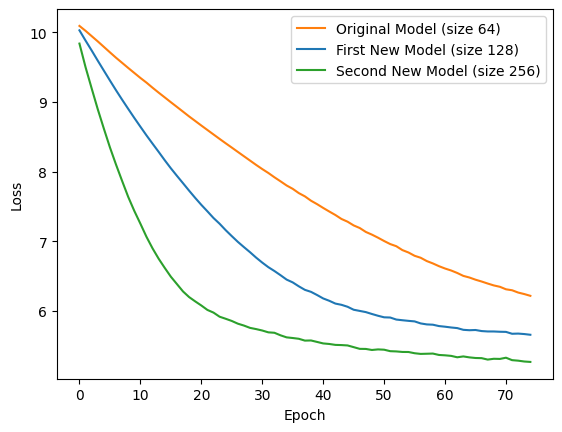

In [23]:
plt.plot(old_model, label="Original Model (size 64)", color="C1")
plt.plot(new_model_1, label="First New Model (size 128)", color="C0")
plt.plot(new_model_2, label="Second New Model (size 256)",color="C2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

As we would expect, increasing the embedding size increases performance on the validation set. However, we find diminishing returns, as the improvement of 128 over 64 is larger than 256 over 128.